# A simple example of generating playlist by multilable learning (toppush)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, label_ranking_loss
from scipy.sparse import lil_matrix, issparse

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from TopPushMLC import TopPushMLC
from evaluate import evaluatePrecision, evalPred

In [3]:
data_dir = 'data'
faotm = os.path.join(data_dir, 'aotm-2011/aotm-2011-subset.pkl')
fmap  = os.path.join(data_dir, 'aotm-2011/songID2TrackID.pkl')
ftag  = os.path.join(data_dir, 'msd/msd_tagtraum_cd2c.cls')

In [4]:
fxtrain = os.path.join(data_dir, 'aotm-2011/XTrain_tag.pkl')
fytrain = os.path.join(data_dir, 'aotm-2011/YTrain.pkl')
fxtest  = os.path.join(data_dir, 'aotm-2011/XTest_tag.pkl')
fytest  = os.path.join(data_dir, 'aotm-2011/YTest.pkl')

## Data loading

Load playlists.

In [5]:
playlists = pkl.load(open(faotm, 'rb'))

In [6]:
print('#Playlists: %d' % len(playlists))

#Playlists: 95298


In [7]:
playlists[0]

['SOFDPDC12A58A7D198',
 'SOPIEQP12A8C13F268',
 'SOKMCJK12A6D4F6105',
 'SOGTGJR12A6310E08D',
 'SOLTBYJ12A6310F2BB',
 'SOBOXXN12A6D4FA1A2',
 'SOUQUFO12B0B80778E']

In [8]:
#print('#Songs: %d' % len({songID for p in playlists for songID in p['filtered_lists'][0]}))

Average playlist length: 9.4


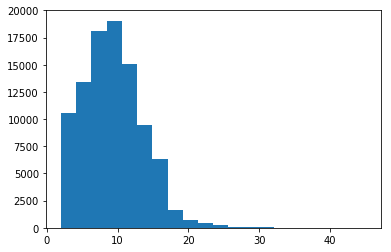

In [9]:
#lengths = [len(p['filtered_lists'][0]) for p in playlists]
lengths = [len(sl) for sl in playlists]
plt.hist(lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(lengths))

Load `song_id` --> `track_id` mapping: a song may correspond to multiple tracks.

In [10]:
song2TrackID = pkl.load(open(fmap, 'rb'))

In [11]:
{ k : song2TrackID[k] for k in list(song2TrackID.keys())[:10] }

{'SOAAAFI12A6D4F9C66': ['TRZEXLQ128F1491D17'],
 'SOAAAMT12AB018C9C4': ['TRYIOYF12903CD4E73'],
 'SOAAASR12AB018A516': ['TRRTOHC12903CDD2EA'],
 'SOAABHX12AAF3B40E7': ['TRZARKN128F92DE096'],
 'SOAABLG12A6D4F73D2': ['TRFUCDA128F1455C96'],
 'SOAABMP12A6D4F7633': ['TRQVPBD128F1458060'],
 'SOAABMR12A6D4F70E4': ['TRVMASA128F149BB53'],
 'SOAABQL12A67020E76': ['TRJOVXI128E0791CFA'],
 'SOAABRB12A58A792A3': ['TRZGOQN128F935F425'],
 'SOAACBE12A6D4F7A54': ['TRHRWOM128F1466747']}

Load song tags, build `track_id` --> `tag` mapping.

In [12]:
track2Tags = dict()

In [13]:
with open(ftag) as f:
    for line in f:
        if line[0] == '#': continue
        tid, tag = line.strip().split('\t')
        #print(tid, tag)
        track2Tags[tid] = tag

In [14]:
print('#(Track, Tag): %d' % len(track2Tags))

#(Track, Tag): 191401


In [15]:
{ k : track2Tags[k] for k in list(track2Tags.keys())[:10] }

{'TRAAAAK128F9318786': 'Rock',
 'TRAAAAW128F429D538': 'Rap',
 'TRAAADJ128F4287B47': 'Rock',
 'TRAAADZ128F9348C2E': 'Latin',
 'TRAAAED128E0783FAB': 'Jazz',
 'TRAAAEF128F4273421': 'Rock',
 'TRAAAEM128F93347B9': 'Electronic',
 'TRAAAGF12903CEC202': 'Pop',
 'TRAAAGR128F425B14B': 'Pop',
 'TRAAAHZ128E0799171': 'Rap'}

## Data cleaning

Use the subset of playlist such that the first song (i.e. the *seed* song) in each playlist has tag(s).

In [16]:
subset_ix = []

In [17]:
seedSong2Tag = { }
for ix in range(len(playlists)):
    # the list of song IDs in the playlist
    #songIDs = playlists[ix]['filtered_lists'][0]
    songIDs = playlists[ix]

    # seed song
    seedSongID   = songIDs[0]
    seedTrackIDs = song2TrackID[seedSongID]
    
    # a song can have multiple tracks, make sure that at least one track for a song has a tag
    flag = [ (trackID in track2Tags) for trackID in seedTrackIDs]
    if not np.any(flag):
        continue

    #seedSong2Tag[playlists[ix]['mix_id']] = [track2Tags[seedTrackIDs[i]] for i in range(len(flag)) if flag[i] is True]
    seedSong2Tag[playlists[ix][0]] = [track2Tags[seedTrackIDs[i]] for i in range(len(flag)) if flag[i] is True]

    subset_ix.append(ix)

In [18]:
#seedSong2Tag

In [19]:
playlists_subset = [playlists[ix] for ix in subset_ix]

In [20]:
print('#Playlists used: %d' % len(subset_ix))

#Playlists used: 48894


In [21]:
playlists_subset[0]

['SORJUFZ12A67ADAF25',
 'SOEELNN12AB018AC8D',
 'SOLVIWU12A58A80754',
 'SOHNSTI12AB01884AE',
 'SOPPRIE12AAA8C598A',
 'SOIETIB12A6701FDE2',
 'SOWVYKE12A8C1351FB',
 'SOMUPJE12A6D4F84DE',
 'SONYSAO12A8C137481',
 'SODYACY12A670213A4',
 'SOBDJHK12AB0183741',
 'SOETDKA12AB0186BF0',
 'SOCZLBB12A8C1430F9',
 'SOFHDFX12A8C13E4C3',
 'SOHXUTT12A6310D9F3',
 'SOKILHY12A6D4F9A70',
 'SOKRNLD12A582911A6',
 'SOUXUPC12A6D4F6215',
 'SOMQIAB12A8C134B02']

The set of unique songs, **in multilabel learning, we have a label for each song in this set**.

In [22]:
song_set = sorted({songID for p in playlists_subset for songID in p})

In [23]:
print('#Songs used: %d' % len(song_set))

#Songs used: 84574


In [24]:
print(song_set[:10])

['SOAAAFI12A6D4F9C66', 'SOAAASR12AB018A516', 'SOAABLG12A6D4F73D2', 'SOAABMP12A6D4F7633', 'SOAABQL12A67020E76', 'SOAACBE12A6D4F7A54', 'SOAACQI12AB017F874', 'SOAACVH12AB017EB86', 'SOAACZY12A6D4F8081', 'SOAADAY12A6D4F9F4C']


## Data analysis

For the most part, playlists contain less than 10 songs. The most common playlist length is 2 songs.

Average playlist length: 9.5


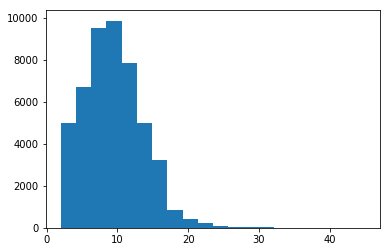

In [25]:
playlist_lengths = [len(p) for p in playlists_subset]
plt.hist(playlist_lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(playlist_lengths))

## One-hot tag encoding

Indicator of tags: `tag` --> `index` mapping.

In [26]:
# the set of unique tags
tag_set = sorted(set(track2Tags.values()))

In [27]:
print('#Tags: %d' % len(tag_set))

#Tags: 15


In [28]:
tag_indicator = { tag: ix for ix, tag in enumerate(tag_set) }

In [29]:
tag_indicator

{'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'Jazz': 4,
 'Latin': 5,
 'Metal': 6,
 'New Age': 7,
 'Pop': 8,
 'Punk': 9,
 'Rap': 10,
 'Reggae': 11,
 'RnB': 12,
 'Rock': 13,
 'World': 14}

## Feature extraction

Build features (1-hot encoding of tag) for a song given its `song_id`.

In [30]:
def gen_features(song_id, song2TrackID = song2TrackID, tag_indicator = tag_indicator):
    """
        Generate one-hot feature vector for a given song ID
    """

    features = np.zeros(len(tag_set), dtype = np.float)
    trackIDs = song2TrackID[song_id]

    cnt = 0
    for trackID in trackIDs:
        if trackID in track2Tags:
            cnt += 1
            tag = track2Tags[trackID]
            tag_ix = tag_indicator[tag]
            features[tag_ix] = 1

    # must have at least one tag for the song, else useless
    assert(cnt >= 1)

    return features

In [31]:
def gen_feature_map(song_id, seed):
    """
        Generate feature mapping for a given (label, query) pair
    """
    
    #return gen_features(song_id) - gen_features(seed)  # feature map
    return gen_features(seed)  # a trivial feature map

In [32]:
def gen_training_set(playlists = playlists_subset, song_set = song_set):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - playlists: which playlists to create features for
            
        Output:
            - (Feature, Label) pair (X, Y), with # num playlists rows
              X comprises the features for each seed song and the given song
              Y comprises the indicators of whether the given song is present in the respective playlist
    """

    N = len(playlists)
    D = len(tag_set)
    K = len(song_set)

    X = np.zeros((N, D), dtype = np.float)
    #Y = np.zeros((N, K), dtype = np.int)
    #Y = coo_matrix(([0], ([0],[0])), shape=(N, K), dtype=np.int8).tolil()
    Y = lil_matrix((N, K), dtype=np.int8)
    
    for i in range(len(playlists)):
        playlist = playlists[i]
        seed     = playlist[0]

        X[i, :] = gen_feature_map(None, seed)
        Y[i, :] = [int(sid in playlist) for sid in song_set]

    return X, Y.tocsr()

In [33]:
gen_feature_map(song_set[100], playlists_subset[0][0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.])

## Training & Test

Train a logistic regression model for each label.

In [34]:
if np.all([os.path.exists(fname) for fname in [fxtrain, fytrain, fxtest, fytest]]):
    X_train = pkl.load(open(fxtrain, 'rb'))
    Y_train = pkl.load(open(fytrain, 'rb'))
    X_test  = pkl.load(open(fxtest,  'rb'))
    Y_test  = pkl.load(open(fytest,  'rb'))
else:
    X, Y = gen_training_set()
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.33, random_state=31)
    pkl.dump(X_train, open(fxtrain, 'wb'))
    pkl.dump(Y_train, open(fytrain, 'wb'))
    pkl.dump(X_test,  open(fxtest,  'wb'))
    pkl.dump(Y_test,  open(fytest,  'wb'))

In [35]:
X_train.shape

(32758, 15)

In [36]:
Y_train.shape

(32758, 84574)

In [37]:
#clf = OneVsRestClassifier(LogisticRegression(verbose=1))
#clf.fit(X_train, Y_train)
#pkl.dump(clf, open(os.path.join(data_dir, 'aotm-2011/br-base.pkl'), 'wb'))

In [69]:
def print_results(predictor, X_train, Y_train, X_test, Y_test):
    """
        Compute and save performance results
    """
    p3_train = []
    p5_train = []
    pk_train = []
    p10_train = []
    p3_test = []
    p5_test = []
    pk_test = []
    p10_test = []
    rankloss_train = []
    rankloss_test = []
    
    N_train = X_train.shape[0]
    batch_size = 500
    N_batch_train = int((N_train-1) / batch_size) + 1
    for i in range(N_batch_train):
        ix0 = i * batch_size
        ix1 = min((i+1) * batch_size, N_train)
        preds = predictor.decision_function(X_train[ix0:ix1])
        evaldict = evaluatePrecision(Y_train[ix0:ix1].toarray(), preds, verbose=-1)
        size = ix1 - ix0
        p3_train.append(evaldict['Precision@3'][0] * size)
        p5_train.append(evaldict['Precision@5'][0] * size)
        pk_train.append(evaldict['Precision@K'][0] * size)
        p10_train.append(evaldict['Precision@10'][0] * size)
        #rankloss_train.append(evalPred1(Y_train[i].toarray()[0], pred, metricType='Ranking'))
        sys.stdout.write('\r%d / %d' % (i+1, N_batch_train)); sys.stdout.flush()
    print()
    
    N_test = X_test.shape[0]
    N_batch_test = int((N_test-1) / batch_size) + 1
    for i in range(N_batch_test):
        ix0 = i * batch_size
        ix1 = min((i+1) * batch_size, N_test)
        preds = predictor.decision_function(X_test[ix0:ix1])
        evaldict = evaluatePrecision(Y_test[ix0:ix1].toarray(), preds, verbose=-1)
        size = ix1 - ix0
        p3_test.append(evaldict['Precision@3'][0] * size)
        p5_test.append(evaldict['Precision@5'][0] * size)
        pk_test.append(evaldict['Precision@K'][0] * size)
        p10_test.append(evaldict['Precision@10'][0] * size)
        #rankloss_test.append(evalPred1(Y_test[i].toarray()[0], pred, metricType='Ranking'))
        sys.stdout.write('\r%d / %d' % (i+1, N_batch_test)); sys.stdout.flush()
    print()
    
    print('Training set:')
    print('Precision@3:', (np.sum(p3_train) / N_train))
    print('Precision@5:', (np.sum(p5_train) / N_train))
    print('Precision@k:', (np.sum(pk_train) / N_train))
    print('Precision@10:', (np.sum(p10_train) / N_train))
    print()
    print('Test set:')
    print('Precision@3:', (np.sum(p3_test) / N_test))
    print('Precision@5:', (np.sum(p5_test) / N_test))
    print('Precision@k:', (np.sum(pk_test) / N_test))
    print('Precision@10:', (np.sum(p10_test) / N_test))
    
    #print()
    #print('Training set:')
    #print('RankingLoss: %.1f, %.1f' % (np.mean(rankloss_train), np.std(rankloss_train) / N_train))
    #print()
    #print('Test set:')
    #print('RankingLoss: %.1f, %.1f' % (np.mean(rankloss_test), np.std(rankloss_test) / N_test))

In [100]:
def print_dataset_info(X_train, Y_train, X_test, Y_test):
    N_train, D = X_train.shape
    K = Y_train.shape[1]
    N_test = X_test.shape[0]
    print('%-45s %s' % ('Number of training examples:', '{:,}'.format(N_train)))
    print('%-45s %s' % ('Number of test examples:', '{:,}'.format(N_test)))
    print('%-45s %s' % ('Number of features:', '{:,}'.format(D)))
    print('%-45s %s' % ('Number of labels:', '{:,}'.format(K)))
    avgK_train = np.mean(np.sum(Y_train, axis=1))
    avgK_test  = np.mean(np.sum(Y_test, axis=1))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (train):', avgK_train, 100*avgK_train / K))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (test):', avgK_test, 100*avgK_test / K))
    #print('%-45s %.4f%%' % ('Average label occurrence (train):', np.mean(np.sum(Y_train, axis=0)) / N_train))
    #print('%-45s %.4f%%' % ('Average label occurrence (test):', np.mean(np.sum(Y_test, axis=0)) / N_test))
    print('%-45s %.3f%%' % ('Sparsity (percent) (train):', 100 * np.sum(Y_train) / np.prod(Y_train.shape)))
    print('%-45s %.3f%%' % ('Sparsity (percent) (test):', 100 * np.sum(Y_test) / np.prod(Y_test.shape)))

In [101]:
print_dataset_info(X_train, Y_train, X_test, Y_test)

Number of training examples:                  32,758
Number of test examples:                      16,136
Number of features:                           15
Number of labels:                             84,574
Average number of positive labels (train):    9.426 (0.01%)
Average number of positive labels (test):     9.454 (0.01%)
Sparsity (percent) (train):                   0.011%
Sparsity (percent) (test):                    0.011%


In [70]:
clf = pkl.load(open(os.path.join(data_dir, 'aotm-2011/br-base.pkl'), 'rb'))
print_results(clf, X_train, Y_train, X_test, Y_test)

66 / 66
33 / 33
Training set:
Precision@3: 0.0
Precision@5: 0.0
Precision@k: 0.0
Precision@10: 0.0

Test set:
Precision@3: 0.000123946455131
Precision@5: 9.91571641051e-05
Precision@k: 0.000109106656578
Precision@10: 6.81705503223e-05


In [83]:
y1 = clf.decision_function(X_train[:1])[0]

In [84]:
Y_train[0].toarray().nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 1839,  3867, 19832, 20123, 23378, 29041, 32092, 34778, 42432,
        44722, 54600, 55310, 57000, 66317, 79696]))

In [98]:
clf2 = TopPushMLC(C=1, r=1)
clf2.fit_SGD(X_train, Y_train, batch_size=500, n_epochs=10, learning_rate=0.01)

 66 / 66
epoch: 1 / 10, obj: 11.699608
 66 / 66
epoch: 2 / 10, obj: 11.439291
 66 / 66
epoch: 3 / 10, obj: 11.370212
 66 / 66
epoch: 4 / 10, obj: 11.351880
 66 / 66
epoch: 5 / 10, obj: 11.347016
 66 / 66
epoch: 6 / 10, obj: 11.345725
 66 / 66
epoch: 7 / 10, obj: 11.345382
 66 / 66
epoch: 8 / 10, obj: 11.345291
 66 / 66
epoch: 9 / 10, obj: 11.345267
 66 / 66
epoch: 10 / 10, obj: 11.345261


In [99]:
print_results(clf2, X_train, Y_train, X_test, Y_test)

66 / 66
33 / 33
Training set:
Precision@3: 0.0157925799296
Precision@5: 0.0136943647353
Precision@k: 0.0120223193487
Precision@10: 0.0117345381281

Test set:
Precision@3: 0.0153280449512
Precision@5: 0.013163113535
Precision@k: 0.0114173808408
Precision@10: 0.011049826475
